<h1>Моделирование стоимости под риском (VaR) методом Монте-Карло</h1>

<p>Разработано Драчуком А. для The Foundation</p>
<a href="https://t.me/LYFTN">Следите за нами в Телеграм</a>

<h3>Импортируем необходимые библиотеки</h3>

In [144]:
import numpy as np        #библиотека для работы с массивами и матрицами
import pandas as pd        #библитека для работы с данными
import datetime as dt        #библиотека для работы с временными рядами
import yfinance as yf        #библиотека для работы с данными с Yahoo Finance
import matplotlib.pyplot as plt        #импорт модуля для формирования графиков из библиотеки для визуализации данных
from scipy.stats import norm        #импорт модуля статистических функций из библиотеки научных функций

<h3>Задаем глубину фактических данных для анализа</h3>

In [145]:
years = 15        #указываем кол-во лет для анализа

endDate = dt.datetime.now()        #задаем конечную дату -- текущий момент времени
startDate = endDate - dt.timedelta(days = 365 * years)        #начальная дата: текущий момент времени - кол-во лет

<h3>Формируем массив тикеров ценных бумаг, из которых формируем портфель</h3>

In [146]:
#SPY -- SPDR S&P 500 ETF Trust
#BND -- Vanguard Total Bond Market Index Fund 
#GLD -- SPDR Gold Shares
#QQQ -- Invesco QQQ Trust
#VTI -- Vanguard Total Stock Market Index Fund ETF Shares 
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [147]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']
    
print(adj_close_df)        #проверяем корректность выгрузки

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-05-28   68.595078  50.030067   94.239998   30.550158   34.613125
2009-05-29   69.809715  50.387772   96.199997   30.926023   35.151817
2009-06-01   71.499710  50.047089   95.730003   31.808876   36.024353
2009-06-02   71.560059  50.236332   96.360001   31.852554   36.168514
2009-06-03   70.654724  50.406010   94.410004   31.756428   35.728462
...                ...        ...         ...         ...         ...
2024-05-17  529.450012  71.809998  223.660004  451.760010  262.299988
2024-05-20  530.059998  71.739998  224.559998  454.910004  262.570007
2024-05-21  531.359985  71.889999  224.229996  455.799988  263.109985
2024-05-22  529.830017  71.800003  220.110001  455.709991  262.220001
2024-05-23  525.960022  71.589996  215.720001  453.660004  259.989990

[3774 rows x 5 columns]


<h3>Преобразовываем массив дневных цен в массив дневных доходностей</h3>

In [148]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))        #рассчитываем натуральный логарифм дневной доходности ценных бумаг
log_returns = log_returns.dropna()        #удаляем строки со значениями NaN 

print(log_returns)        #проверяем массив

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-05-29  0.017552  0.007124  0.020585  0.012228  0.015443
2009-06-01  0.023920 -0.006784 -0.004898  0.028147  0.024519
2009-06-02  0.000844  0.003774  0.006559  0.001372  0.003994
2009-06-03 -0.012732  0.003372 -0.020444 -0.003022 -0.012241
2009-06-04  0.009352 -0.006233  0.019094  0.011222  0.009931
...              ...       ...       ...       ...       ...
2024-05-17  0.001437 -0.002503  0.016363 -0.000487  0.001412
2024-05-20  0.001151 -0.000975  0.004016  0.006949  0.001029
2024-05-21  0.002450  0.002089 -0.001471  0.001954  0.002054
2024-05-22 -0.002883 -0.001253 -0.018545 -0.000197 -0.003388
2024-05-23 -0.007331 -0.002929 -0.020146 -0.004509 -0.008541

[3773 rows x 5 columns]


<h3>Пишем функции ожидаемой доходности и риска инвестиционного портфеля</h3>

In [159]:
#функция ожидаемой доходности инвестиционного портфеля -- средневзвешенная доходность отдельных инструментов в его составе
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)

In [160]:
#функция риска портфеля
def standard_deviation(weights, cov_matrix): 
        variance = weights.T @ cov_matrix @ weights 
        return np.sqrt(variance)

In [161]:
#формируем ковариационную матрицу
cov_matrix = log_returns.cov()

print(cov_matrix)        #проверяем результат

              SPY           BND       GLD           QQQ           VTI
SPY  1.179564e-04 -2.617007e-07  0.000007  1.296244e-04  1.203842e-04
BND -2.617007e-07  9.222794e-06  0.000009  6.121896e-07 -6.273559e-08
GLD  7.049476e-06  8.611406e-06  0.000097  7.843420e-06  7.635376e-06
QQQ  1.296244e-04  6.121896e-07  0.000008  1.654628e-04  1.324884e-04
VTI  1.203842e-04 -6.273559e-08  0.000008  1.324884e-04  1.239176e-04


<h3>Формируем базовый сценарий моделирования -- равновесный инвестиционый портфель</h3>

In [162]:
portfolio_value = 1000000        #стоимость портфеля
weights = np.array([1/len(tickers)] * len(tickers))        #формируем массив из одинаковых весов
portfolio_expected_return = expected_return(weights, log_returns)        #находим ожидаемую доходность равновесного портфеля
portfolio_std_dev = standard_deviation(weights, cov_matrix)        #находим риск равновесного портфеля

print(weights)        #проверяем веса

[0.2 0.2 0.2 0.2 0.2]


<h3>Формируем функцию случайного z-значения на основе нормального распределения</h3>

In [163]:
def random_z_score():
    return np.random.normal(0,1)

<h3>Задаем функцию стоимости портфеля на рассматриваемом периоде прогнозирования</h3>

In [164]:
days = 5        #кол-во дней, для которого рассчитывается стоимость под риском

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

<h3>Моделируем случайные результаты методом Монте-Карло</h3>

In [168]:
simulations = 10000        #задаем кол-во итераций для моделирования методом Монте-Карло
scenarioReturn = []        #задаем пустой массив 

#запускаем симуляцию
for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

<h3>Задаем доверительный интервал и рассчитываем Стоимость под риском (VaR) на заданном временном горизонте</h3>

In [170]:
confidence_interval = 0.95        #доверительный интервал

VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))        #рассчитываем VaR

print(VaR)        #выводим результат 

25228.077035301667


<h3>Визуализируем результаты моделирования Монте-Карло на график</h3>

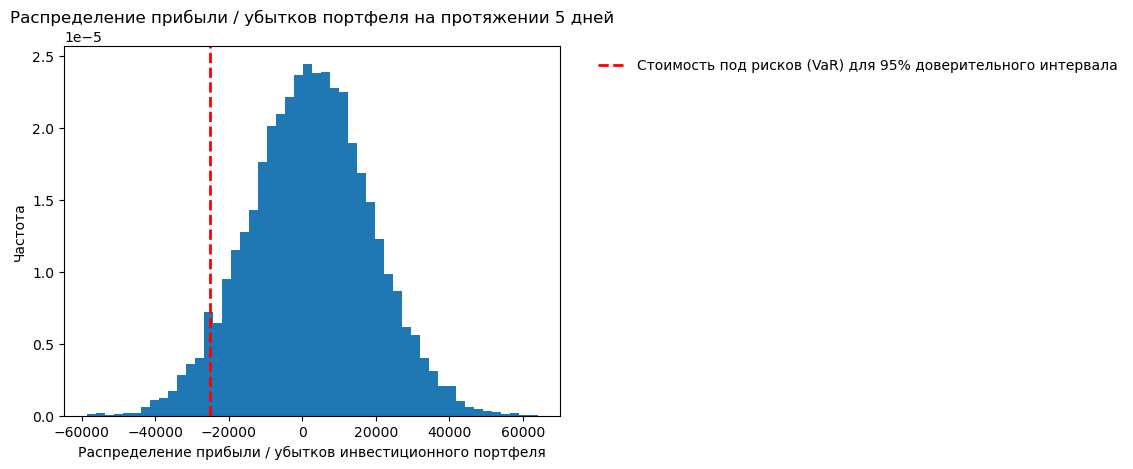

In [171]:
plt.hist(scenarioReturn, bins = 50, density = True)
plt.xlabel('Распределение прибыли / убытков инвестиционного портфеля')
plt.ylabel('Частота')
plt.title(label=f'Распределение прибыли / убытков портфеля на протяжении {days} дней')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, 
            label = f'Стоимость под рисков (VaR) для {confidence_interval:.0%} доверительного интервала')
plt.legend(loc='upper center', bbox_to_anchor=(1.6, 1.0),
          frameon=False, shadow=False, ncol=5)
plt.show()